# Nome: Raylander Marques Melo
# Matrícula: 586108

In [280]:
!pip install numpy scikit-learn matplotlib pandas Jinja2 seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


In [281]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [277]:
class MLP:
    def __init__(self, input_size, hidden_sizes, output_size, problem_type='classification'):
        self.layer_sizes = [input_size] + hidden_sizes + [output_size]
        self.problem_type = problem_type
        self.output_size = output_size
        
        # Inicialização dos pesos com escala apropriada
        self.weights = []
        self.biases = []
        for i in range(len(self.layer_sizes)-1):
            # Inicialização He para ReLU
            std = np.sqrt(2.0 / self.layer_sizes[i])
            self.weights.append(np.random.randn(self.layer_sizes[i], self.layer_sizes[i+1]) * std)
            self.biases.append(np.zeros((1, self.layer_sizes[i+1])))
        
        # Para momentum
        self.prev_weight_updates = [np.zeros_like(w) for w in self.weights]
        self.prev_bias_updates = [np.zeros_like(b) for b in self.biases]
    
    def relu(self, x):
        return np.maximum(0, x)
    
    def relu_derivative(self, x):
        return (x > 0).astype(float)

    def sigmoid(self, x):
        x_clipped = np.clip(x, -50, 50)
        return 1 / (1 + np.exp(-x_clipped))

    def stable_softmax(self, x):
        shiftx = x - np.max(x, axis=1, keepdims=True)
        exps = np.exp(shiftx)
        
        return exps / (np.sum(exps, axis=1, keepdims=True) + 1e-15)

    def forward(self, x):
        self.activations = [x]
        self.z_values = []
        
        try:
            # Camadas ocultas
            for i in range(len(self.weights)-1):
                z = np.dot(self.activations[-1], self.weights[i]) + self.biases[i]
                self.z_values.append(z)
                self.activations.append(self.relu(z))
            
            # Camada de saída
            z_output = np.dot(self.activations[-1], self.weights[-1]) + self.biases[-1]
            
            # Função de ativação final
            if self.problem_type == 'classification':
                if self.output_size == 1:
                    output = self.sigmoid(z_output)
                else:
                    output = self.stable_softmax(z_output)
            else:
                output = z_output  # Regressão
            
            self.activations.append(output)
            return output
        
        except Exception as e:
            print(f"Erro no forward pass: {str(e)}")
            print("Valores intermediários:")
            print(f"Última ativação: {self.activations[-1].min()}, {self.activations[-1].max()}")
            print(f"Últimos pesos: {self.weights[-1].min()}, {self.weights[-1].max()}")
            raise

    def backward(self, X, y, learning_rate, l2_lambda=0.0):
        try:
            output = self.forward(X)
            batch_size = X.shape[0]
            
            # Clip dos gradientes para evitar explosão
            grad_clip = 1.0 
            
            if self.problem_type == 'classification':
                delta = np.clip((output - y) / batch_size, -grad_clip, grad_clip)
            else:
                delta = np.clip(2 * (output - y) / batch_size, -grad_clip, grad_clip)
            
            # Backpropagation
            grads_w = []
            grads_b = []
            
            # Última camada
            dW = np.clip(np.dot(self.activations[-2].T, delta) + l2_lambda * self.weights[-1], -grad_clip, grad_clip)
            dB = np.clip(np.sum(delta, axis=0, keepdims=True), -grad_clip, grad_clip)
            grads_w.append(dW)
            grads_b.append(dB)
            
            # Camadas ocultas
            for i in range(len(self.weights)-2, -1, -1):
                delta = np.clip(np.dot(delta, self.weights[i+1].T) * self.relu_derivative(self.z_values[i]), -grad_clip, grad_clip)
                dW = np.clip(np.dot(self.activations[i].T, delta) + l2_lambda * self.weights[i], -grad_clip, grad_clip)
                dB = np.clip(np.sum(delta, axis=0, keepdims=True), -grad_clip, grad_clip)
                grads_w.insert(0, dW)
                grads_b.insert(0, dB)
            
            # Atualização com momentum
            for i in range(len(self.weights)):
                weight_update = learning_rate * grads_w[i] + self.momentum * self.prev_weight_updates[i]
                bias_update = learning_rate * grads_b[i] + self.momentum * self.prev_bias_updates[i]
                
                self.weights[i] -= weight_update
                self.biases[i] -= bias_update
                
                self.prev_weight_updates[i] = weight_update
                self.prev_bias_updates[i] = bias_update
                
        except Exception as e:
            print(f"Erro no backward pass: {str(e)}")
            raise


    def compute_loss(self, y_pred, y_true, l2_lambda=0.0):
        # Loss principal
        if self.problem_type == 'classification':
            y_pred = np.clip(y_pred, 1e-15, 1-1e-15)
            loss = -np.mean(y_true * np.log(y_pred) + (1-y_true) * np.log(1-y_pred))
        else:
            loss = np.mean((y_pred - y_true)**2)
        
        # Regularização L2
        if l2_lambda > 0:
            l2_penalty = sum(np.sum(w**2) for w in self.weights)
            loss += 0.5 * l2_lambda * l2_penalty
        
        return loss

    def train(self, X, y, X_val=None, y_val=None, 
             epochs=1000, learning_rate=0.001, batch_size=32,
             momentum=0.9, l2_lambda=0.01, verbose=True):
        
        self.momentum = momentum
        history = {'train_loss': [], 'val_loss': [], 'train_metrics': [], 'val_metrics': []}
        
        for epoch in range(epochs):
            # Minibatch SGD
            permutation = np.random.permutation(X.shape[0])
            for i in range(0, X.shape[0], batch_size):
                batch_idx = permutation[i:i+batch_size]
                X_batch, y_batch = X[batch_idx], y[batch_idx]
                self.backward(X_batch, y_batch, learning_rate, l2_lambda)
            
            # Métricas de treino
            train_pred = self.forward(X)
            train_loss = self.compute_loss(train_pred, y, l2_lambda)
            train_metrics = self.compute_metrics(train_pred, y)
            history['train_loss'].append(train_loss)
            history['train_metrics'].append(train_metrics)
            
            # Métricas de validação
            if X_val is not None:
                val_pred = self.forward(X_val)
                val_loss = self.compute_loss(val_pred, y_val, l2_lambda)
                val_metrics = self.compute_metrics(val_pred, y_val)
                history['val_loss'].append(val_loss)
                history['val_metrics'].append(val_metrics)
            
            if verbose and epoch % 100 == 0:
                log = f"Epoch {epoch}: Train Loss = {train_loss:.4f}"
                if X_val is not None:
                    log += f", Val Loss = {val_loss:.4f}"
                print(log)
        
        return history

    def compute_metrics(self, y_pred, y_true):
        metrics = {}
        
        if self.problem_type == 'classification':
            if self.output_size == 1:  # Binária
                y_pred_class = (y_pred > 0.5).astype(int)
                metrics['accuracy'] = accuracy_score(y_true, y_pred_class)
            else:  # Multiclasse
                y_pred_class = np.argmax(y_pred, axis=1)
                y_true_class = np.argmax(y_true, axis=1)
                metrics['accuracy'] = accuracy_score(y_true_class, y_pred_class)
        else:  # Regressão
            metrics['mse'] = np.mean((y_pred - y_true)**2)
            metrics['r2'] = r2_score(y_true, y_pred)
        
        return metrics

    def predict(self, X):
        preds = self.forward(X)
        if self.problem_type == 'classification':
            return (preds > 0.5).astype(int) if self.output_size == 1 else np.argmax(preds, axis=1)
        return preds

In [3]:
def train_test_split(X, y, test_size=0.2, val_size=0.2, random_state=None):
    """Divide os dados em treino, validação e teste"""
    if random_state:
        np.random.seed(random_state)
        
    n_samples = len(X)
    indices = np.random.permutation(n_samples)
    
    test_split = int(n_samples * test_size)
    val_split = test_split + int(n_samples * val_size)
    
    test_idx = indices[:test_split]
    val_idx = indices[test_split:val_split]
    train_idx = indices[val_split:]
    
    return X[train_idx], X[val_idx], X[test_idx], y[train_idx], y[val_idx], y[test_idx]

# Questão 1: Considere o conjunto de dados disponível em concrete.csv, organizado em 9 colunas, sendo as 8 primeiras colunas os atributos e a última coluna a saída. Os 8 atributos referem-se à caracterização de diferentes tipos de concreto para construção civil. A saída é a resistência à compressão do concreto (em me- gapascals, MPa). Maiores detalhes sobre os dados podem ser conferidos em https://www.openml.org/d/4353.

In [30]:
data = np.genfromtxt('concrete.csv', delimiter=',')
X = data[:,:-1]
y = data[:,-1].astype(int)
y = y.reshape(-1, 1)
print(X.shape, y.shape)

(1030, 8) (1030, 1)


## Questão 1 a) Considere um modelo de regressão não linear baseado em redes neurais artificiais. Separe os dados aleatoriamente em treino, validação e teste (por exemplo, 60%, 20% e 20%). Nesse cenário, treine e avalie o modelo abaixo:

### – MLP (multilayer perceptron): 1 camada oculta e treinamento em minibatch via gradiente descendente estocástico com termo de momentum. Utilize o conjunto de validação para ajustar os hiperparâmetros.

In [202]:

X_train, X_val, X_test, y_train, y_val, y_test = train_test_split(
    X, y, test_size=0.2, val_size=0.25, random_state=42
)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
mlp = MLP(input_size=8, hidden_sizes=[100], output_size=1, problem_type='regression')

history = mlp.train(X_train, y_train, X_val, y_val,
                   epochs=1000, learning_rate=0.001,
                   momentum=0.85, l2_lambda=0.001)

# Métricas finais
print("R² final:", history['train_metrics'][-1]['r2'])

Epoch 0: Train Loss = 1095.2071, Val Loss = 1134.3083
Epoch 100: Train Loss = 25.1285, Val Loss = 44.4166
Epoch 200: Train Loss = 16.1068, Val Loss = 38.3789
Epoch 300: Train Loss = 13.2619, Val Loss = 35.6809
Epoch 400: Train Loss = 11.3678, Val Loss = 37.2148
Epoch 500: Train Loss = 10.6948, Val Loss = 36.2897
Epoch 600: Train Loss = 9.3439, Val Loss = 35.8927
Epoch 700: Train Loss = 8.8205, Val Loss = 38.1366
Epoch 800: Train Loss = 10.1939, Val Loss = 35.4476
Epoch 900: Train Loss = 7.9349, Val Loss = 35.7232
R² final: 0.972493529943697


## Questão 1 b) Apresente as curvas da função custo nos conjuntos de treinamento e validação ao longo das épocas. Reporte também para os conjuntos de treino, validação e teste as métricas abaixo:

### – RMSE (root mean squared error):

### – MAE (mean absolute error):

### – MRE (mean relative error):

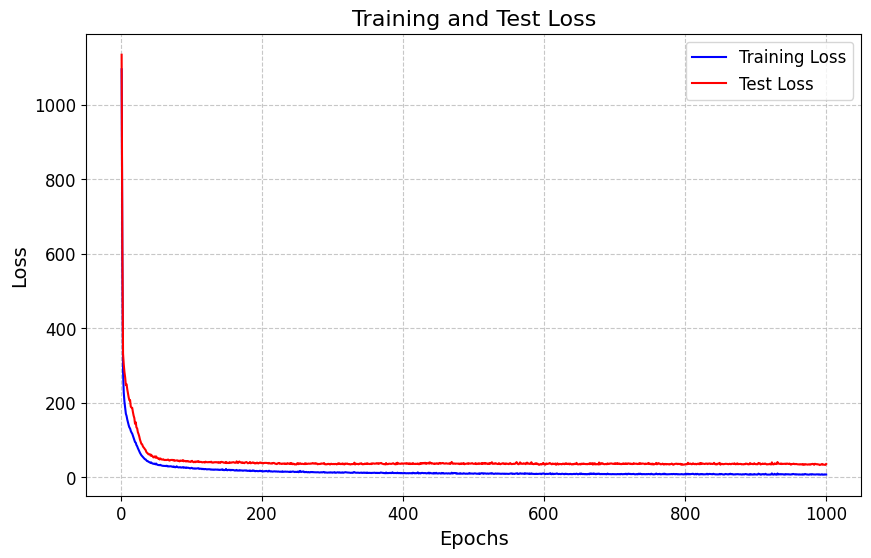

RMSE de treino: 2.6950696266740897 
RMSE de validação: 5.93985261153631 
RMSE de teste: 5.652466458821821 

MAE de treino: 1.9305266817323292 
MAE de validação: 4.202709014635179 
MAE de teste: 4.0013044320931535 

MRE de treino: 0.0724124114221582 
MRE de validação: 0.152419934738673 
MRE de teste: 0.13154962347822402 



In [204]:
epochs_range = range(1, len(history['train_loss']) + 1) 
plt.figure(figsize=(10, 6))
plt.plot(epochs_range, history['train_loss'], 'b-', label='Training Loss')
plt.plot(epochs_range, history['val_loss'], 'r-', label='Test Loss')
plt.title('Training and Test Loss', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# RMSE treino, validação e teste
rmse_treino = np.sqrt(np.sum(np.square(y_train - mlp.predict(X_train)))/len(X_train))
rmse_validacao = np.sqrt(np.sum(np.square(y_val - mlp.predict(X_val)))/len(X_val))
rmse_teste = np.sqrt(np.sum(np.square(y_test - mlp.predict(X_test)))/len(X_test))
print(f"RMSE de treino: {rmse_treino} \nRMSE de validação: {rmse_validacao} \nRMSE de teste: {rmse_teste} \n")
# MAE treino, validação e teste
mae_treino = np.sum(np.abs(y_train - mlp.predict(X_train)))/len(X_train)
mae_validacao = np.sum(np.abs(y_val - mlp.predict(X_val)))/len(X_val)
mae_teste = np.sum(np.abs(y_test - mlp.predict(X_test)))/len(X_test)
print(f"MAE de treino: {mae_treino} \nMAE de validação: {mae_validacao} \nMAE de teste: {mae_teste} \n")
# MRE treino, validação e teste
mre_treino = np.sum(np.abs(y_train - mlp.predict(X_train))/y_train)/len(X_train)
mre_validacao = np.sum(np.abs(y_val - mlp.predict(X_val))/y_val)/len(X_val)
mre_teste = np.sum(np.abs(y_test - mlp.predict(X_test))/y_test)/len(X_test)
print(f"MRE de treino: {mre_treino} \nMRE de validação: {mre_validacao} \nMRE de teste: {mre_teste} \n")

# Questão 2: Considere o conjunto de dados disponível em vowel.csv, organizado em 11 colunas, sendo as 10 primeiras colunas os atributos e a última coluna a saída. Os 10 atributos referem-se à caracterização de amostras da fala de britânicos. A saída é o fonema de vogal correspondente, dentre as 11 possibilidades. Maiores detalhes sobre os dados podem ser conferidos em https://www.openml.org/d/307.

In [4]:
data = np.genfromtxt('vowel.csv', delimiter=',')
X2 = data[:,:-1]
y2 = data[:,-1].astype(int)
y2 = y2.reshape(-1, 1)
print(X2.shape, y2.shape)

(990, 10) (990, 1)


## Questão 2 a) Considere um modelo de classificação não linear baseado em redes neurais artificiais. Separe os dados aleatoriamente em treino, validação e teste (por exemplo, 60%, 20% e 20%). Nesse cenário, treine e avalie o modelo abaixo:

### – MLP (multilayer perceptron): 1 camada oculta e treinamento em minibatch via gradiente descendente estocástico com termo de momentum. Utilize o conjunto de validação para ajustar os hiperparâmetros.

In [285]:
X_train, X_val, X_test, y_train, y_val, y_test = train_test_split(
    X2, y2, test_size=0.2, val_size=0.25, random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

hot_encoder = OneHotEncoder(sparse_output=False)

mlp = MLP(input_size=10, hidden_sizes=[40], output_size=11, problem_type='classification')
history = mlp.train(X_train, hot_encoder.fit_transform(y_train.reshape(-1,1)), X_val, hot_encoder.fit_transform(y_val.reshape(-1,1)), 
                   epochs=10000, learning_rate=0.001, 
                   momentum=0.8, l2_lambda=0.01,batch_size=16)

Epoch 0: Train Loss = 0.8831, Val Loss = 0.8888
Epoch 100: Train Loss = 0.6290, Val Loss = 0.6440
Epoch 200: Train Loss = 0.5925, Val Loss = 0.6090
Epoch 300: Train Loss = 0.5709, Val Loss = 0.5884
Epoch 400: Train Loss = 0.5560, Val Loss = 0.5745
Epoch 500: Train Loss = 0.5460, Val Loss = 0.5648
Epoch 600: Train Loss = 0.5398, Val Loss = 0.5590
Epoch 700: Train Loss = 0.5353, Val Loss = 0.5551
Epoch 800: Train Loss = 0.5319, Val Loss = 0.5522
Epoch 900: Train Loss = 0.5295, Val Loss = 0.5495
Epoch 1000: Train Loss = 0.5279, Val Loss = 0.5481
Epoch 1100: Train Loss = 0.5267, Val Loss = 0.5465
Epoch 1200: Train Loss = 0.5256, Val Loss = 0.5458
Epoch 1300: Train Loss = 0.5246, Val Loss = 0.5450
Epoch 1400: Train Loss = 0.5238, Val Loss = 0.5441
Epoch 1500: Train Loss = 0.5230, Val Loss = 0.5438
Epoch 1600: Train Loss = 0.5224, Val Loss = 0.5427
Epoch 1700: Train Loss = 0.5218, Val Loss = 0.5430
Epoch 1800: Train Loss = 0.5209, Val Loss = 0.5417
Epoch 1900: Train Loss = 0.5204, Val Loss =

## Questão 2 b) Apresente as curvas da função custo nos conjuntos de treinamento e validação ao longo das épocas. Reporte também a acurácia obtida para os conjuntos de treino, validação e teste. Por último, mostre a matriz de confusão obtida no conjunto de teste.

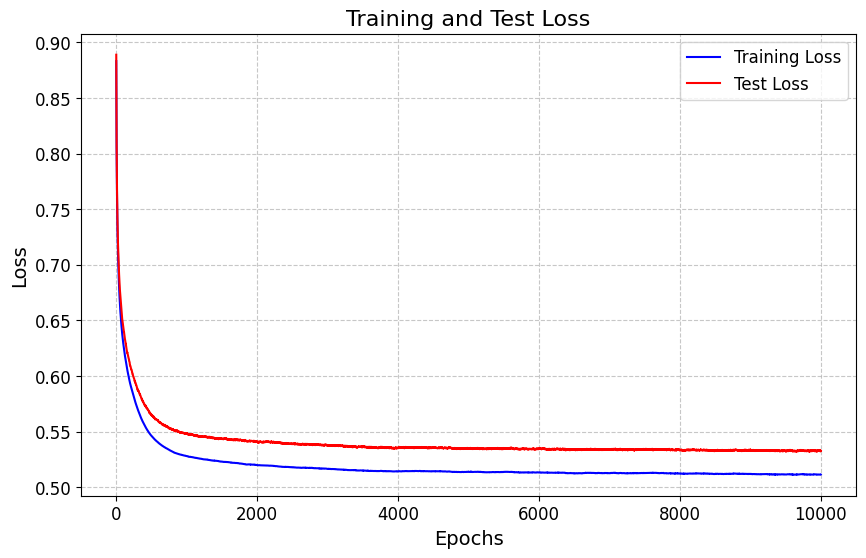

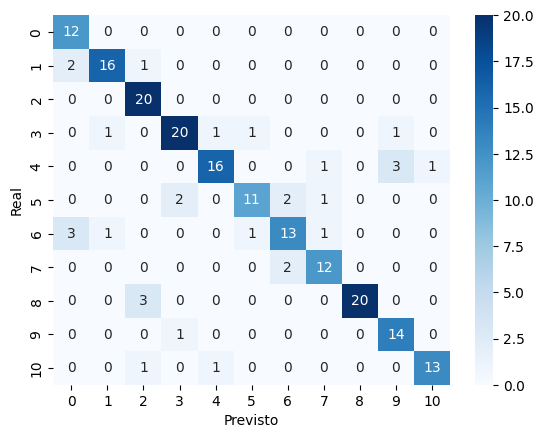

Acurácia de treino: 0.9559633027522936 
Acurácia de validação: 0.8461538461538461 
Acurácia de teste: 0.8434343434343434 



In [286]:
epochs_range = range(1, len(history['train_loss']) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs_range, history['train_loss'], 'b-', label='Training Loss')
plt.plot(epochs_range, history['val_loss'], 'r-', label='Test Loss')
plt.title('Training and Test Loss', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# Criar matriz
matriz = confusion_matrix(y_test,  mlp.predict(X_test))

# Visualizar
sns.heatmap(matriz, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.show()


# Acurácia treino, validação e teste
acuracy_treino = accuracy_score(y_train,mlp.predict(X_train))
acuracy_validacao = accuracy_score(y_val, mlp.predict(X_val))
acuracy_teste = accuracy_score(y_test, mlp.predict(X_test))
print(f"Acurácia de treino: {acuracy_treino} \nAcurácia de validação: {acuracy_validacao} \nAcurácia de teste: {acuracy_teste} \n")
